<a href="https://colab.research.google.com/github/amer676dark/neuralnetworksproject/blob/main/Neural_Networks_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("brianleung2020/eeg-motor-movementimagery-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.87G/1.87G [00:17<00:00, 112MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/brianleung2020/eeg-motor-movementimagery-dataset/versions/1


In [3]:

# %%
# 0. Setup: install dependencies
# Run this cell first in Colab
!pip install -q mne pyEDFlib librosa soundfile kagglehub tensorflow scikit-learn matplotlib plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 78.9 MB/s eta 0:00:00


In [4]:
# %%
# 1. Imports and config
import os
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
import mne
import librosa

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


In [5]:

# %%
# 2. Point this to the dataset directory you already downloaded with kagglehub
# You showed the dataset path earlier; replace below if different
DATASET_ROOT = '/root/.cache/kagglehub/datasets/brianleung2020/eeg-motor-movementimagery-dataset/versions/1'
print('Dataset root:', DATASET_ROOT)


Dataset root: /root/.cache/kagglehub/datasets/brianleung2020/eeg-motor-movementimagery-dataset/versions/1


In [6]:

# %%
# 3. Utilities: list EDF files and extract subject id from filename
edf_paths = glob.glob(os.path.join(DATASET_ROOT, '**', '*.edf'), recursive=True)
edf_paths = sorted(edf_paths)
print('Found EDF files:', len(edf_paths))

def subject_id_from_path(p):
    # Dataset filenames often contain 'S001' or 'S001R01' etc.
    m = re.search(r'[sS](\d{1,3})', os.path.basename(p))
    if m:
        return int(m.group(1))
    # fallback: folder name
    m2 = re.search(r'\d{1,3}', os.path.basename(os.path.dirname(p)))
    return int(m2.group(0)) if m2 else None

# Quick check of first few files
for p in edf_paths[:5]:
    print(p, '->', subject_id_from_path(p))


Found EDF files: 1526
/root/.cache/kagglehub/datasets/brianleung2020/eeg-motor-movementimagery-dataset/versions/1/files/S001/S001R01.edf -> 1
/root/.cache/kagglehub/datasets/brianleung2020/eeg-motor-movementimagery-dataset/versions/1/files/S001/S001R02.edf -> 1
/root/.cache/kagglehub/datasets/brianleung2020/eeg-motor-movementimagery-dataset/versions/1/files/S001/S001R03.edf -> 1
/root/.cache/kagglehub/datasets/brianleung2020/eeg-motor-movementimagery-dataset/versions/1/files/S001/S001R04.edf -> 1
/root/.cache/kagglehub/datasets/brianleung2020/eeg-motor-movementimagery-dataset/versions/1/files/S001/S001R05.edf -> 1


In [7]:

# 4. Parameters for preprocessing and segmentation
SAMPLE_RATE = 128  # Hz after resampling
WINDOW_SECONDS = 2.0  # window length in seconds
WINDOW_SAMPLES = int(SAMPLE_RATE * WINDOW_SECONDS)
FMIN, FMAX = 1.0, 40.0  # bandpass filter range
N_MELS = 64  # frequency bins in spectrogram
HOP_LENGTH = 64  # hop length for STFT


In [8]:

# %%
# 5. Function: load EDF, pick EEG channels, preprocess, and segment into windows
# WARNING: this loop can take time. For a full dataset run, expect many minutes to hours.

def process_file_to_spectrograms(edf_path, max_windows_per_file=50):
    try:
        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
    except Exception as e:
        print('Failed to read', edf_path, e)
        return [], []
    # Pick EEG channels only (MNE auto-detects channel types)
    picks = mne.pick_types(raw.info, eeg=True, meg=False)
    if len(picks) == 0:
        # fallback: use all channels
        data = raw.get_data()
    else:
        data = raw.get_data(picks)
    # Average across channels to produce a single-channel signal (simple approach)
    # Alternative: use multiple channels as multi-channel input (more complex)
    sig = np.mean(data, axis=0)
    # Resample
    raw_resamp = mne.io.RawArray(sig[np.newaxis, :], mne.create_info(ch_names=['EEGavg'], sfreq=raw.info['sfreq']))
    raw_resamp.resample(SAMPLE_RATE, npad='auto')
    sig_rs = raw_resamp.get_data().squeeze()
    # Bandpass
    sig_rs = mne.filter.filter_data(sig_rs, SAMPLE_RATE, l_freq=FMIN, h_freq=FMAX, verbose=False)
    # Segment into windows
    n_samples = len(sig_rs)
    step = WINDOW_SAMPLES  # non-overlapping windows
    specs = []
    for start in range(0, n_samples - WINDOW_SAMPLES + 1, step):
        w = sig_rs[start:start + WINDOW_SAMPLES]
        # Compute mel-spectrogram (log power)
        S = librosa.feature.melspectrogram(y=w.astype(float), sr=SAMPLE_RATE, n_mels=N_MELS, hop_length=HOP_LENGTH)
        S_db = librosa.power_to_db(S, ref=np.max)
        # Normalize per spectrogram
        S_db = (S_db - S_db.mean()) / (S_db.std() + 1e-8)
        specs.append(S_db.astype(np.float32))
        if max_windows_per_file and len(specs) >= max_windows_per_file:
            break
    return specs, len(specs)


Creating RawArray with float64 data, n_channels=1, n_times=9760
    Range : 0 ... 9759 =      0.000 ...    60.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=9760
    Range : 0 ... 9759 =      0.000 ...    60.994 secs
Ready.


/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=256
  warnings.warn(


Creating RawArray with float64 data, n_channels=1, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=20000
    Range : 0 ... 19999 =      0.000 ..

/tmp/ipython-input-878410748.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-878410748.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Creating RawArray with float64 data, n_channels=1, n_times=15744
    Range : 0 ... 15743 =      0.000 ...   122.992 secs
Ready.
Sampling frequency of the instance is already 128.0, returning unmodified.
Creating RawArray with float64 data, n_channels=1, n_times=15744
    Range : 0 ... 15743 =      0.000 ...   122.992 secs
Ready.
Sampling frequency of the instance is already 128.0, returning unmodified.


/tmp/ipython-input-878410748.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-878410748.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Creating RawArray with float64 data, n_channels=1, n_times=15744
    Range : 0 ... 15743 =      0.000 ...   122.992 secs
Ready.
Sampling frequency of the instance is already 128.0, returning unmodified.
Creating RawArray with float64 data, n_channels=1, n_times=15744
    Range : 0 ... 15743 =      0.000 ...   122.992 secs
Ready.
Sampling frequency of the instance is already 128.0, returning unmodified.


/tmp/ipython-input-878410748.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-878410748.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Creating RawArray with float64 data, n_channels=1, n_times=15744
    Range : 0 ... 15743 =      0.000 ...   122.992 secs
Ready.
Sampling frequency of the instance is already 128.0, returning unmodified.
Creating RawArray with float64 data, n_channels=1, n_times=15744
    Range : 0 ... 15743 =      0.000 ...   122.992 secs
Ready.
Sampling frequency of the instance is already 128.0, returning unmodified.


/tmp/ipython-input-878410748.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-878410748.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Creating RawArray with float64 data, n_channels=1, n_times=15744
    Range : 0 ... 15743 =      0.000 ...   122.992 secs
Ready.
Sampling frequency of the instance is already 128.0, returning unmodified.
Creating RawArray with float64 data, n_channels=1, n_times=15744
    Range : 0 ... 15743 =      0.000 ...   122.992 secs
Ready.
Sampling frequency of the instance is already 128.0, returning unmodified.


/tmp/ipython-input-878410748.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-878410748.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Creating RawArray with float64 data, n_channels=1, n_times=15744
    Range : 0 ... 15743 =      0.000 ...   122.992 secs
Ready.
Sampling frequency of the instance is already 128.0, returning unmodified.
Creating RawArray with float64 data, n_channels=1, n_times=15744
    Range : 0 ... 15743 =      0.000 ...   122.992 secs
Ready.
Sampling frequency of the instance is already 128.0, returning unmodified.


/tmp/ipython-input-878410748.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-878410748.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Creating RawArray with float64 data, n_channels=1, n_times=9760
    Range : 0 ... 9759 =      0.000 ...    60.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=9760
    Range : 0 ... 9759 =      0.000 ...    60.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   

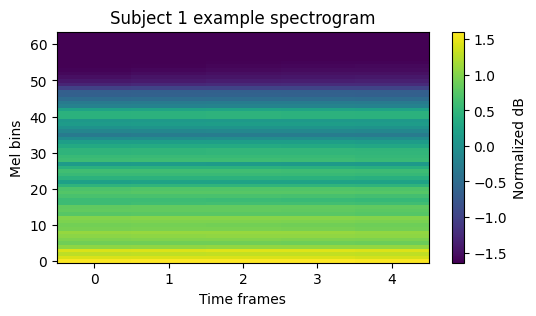

In [9]:

# %%
# 6. Build dataset across files (This will take time; consider running on a subset first)
MAX_FILES = None  # set to an int to limit files while debugging
MAX_WINDOWS_PER_FILE = 30  # limit windows per file to speed up processing

X = []
Y = []
file_count = 0
for p in edf_paths:
    sid = subject_id_from_path(p)
    if sid is None:
        continue
    specs, count = process_file_to_spectrograms(p, max_windows_per_file=MAX_WINDOWS_PER_FILE)
    for s in specs:
        X.append(s)
        Y.append(sid - 1)  # zero-based labels (0..108)
    file_count += 1
    if MAX_FILES and file_count >= MAX_FILES:
        break

X = np.array(X)
Y = np.array(Y)
print('Collected spectrograms:', X.shape, 'labels:', Y.shape)

# %%
# Quick sanity plot
if len(X) > 0:
    plt.figure(figsize=(6,3))
    plt.imshow(X[0], aspect='auto', origin='lower')
    plt.title(f'Subject {Y[0]+1} example spectrogram')
    plt.xlabel('Time frames')
    plt.ylabel('Mel bins')
    plt.colorbar(label='Normalized dB')
    plt.show()

In [10]:


# %%
# 7. Prepare data for model
# We'll use input shape: (freq_bins, time_frames, 1)
X = X[..., np.newaxis]
num_classes = len(np.unique(Y))
print('Num classes detected:', num_classes)

# Stratified split
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42, stratify=train_y)

print('Train/Val/Test shapes:', train_X.shape, val_X.shape, test_X.shape)

# One-hot labels for Keras
train_y_cat = utils.to_categorical(train_y, num_classes)
val_y_cat = utils.to_categorical(val_y, num_classes)
test_y_cat = utils.to_categorical(test_y, num_classes)

Num classes detected: 109
Train/Val/Test shapes: (29291, 64, 5, 1) (7323, 64, 5, 1) (9154, 64, 5, 1)


In [11]:

# %%
# 8. Build the Time-Frequency CNN + Temporal RNN model
freq_bins, time_frames, _ = train_X.shape[1:]
input_shape = (freq_bins, time_frames, 1)
inputs = layers.Input(shape=input_shape)
# Conv block
x = layers.Conv2D(16, (5,5), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2,2))(x)
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2,2))(x)
# Now we want a temporal sequence across time-frames dimension
# Current shape: (batch, f', t', channels)
# Permute to (batch, t', f'*channels)
shape = tf.keras.backend.int_shape(x)
# flatten frequency+channels per time-step
x = layers.Permute((2,1,3))(x)  # now time axis is first
t = layers.TimeDistributed(layers.Flatten())(x)
# GRU layers
t = layers.GRU(128, return_sequences=True)(t)
t = layers.GRU(64)(t)
# Classifier
out = layers.Dense(num_classes, activation='softmax')(t)
model = models.Model(inputs=inputs, outputs=out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 5, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 5, 16)      │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 5, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 2, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 2, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 1, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 512)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 1, 128)         │       246,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 109)            │         7,085 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,109 (1.13 MB)

 Trainable params: 296,013 (1.13 MB)

 Non-trainable params: 96 (384.00 B)

In [12]:


# %%
# 9. Training
es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(train_X, train_y_cat, validation_data=(val_X, val_y_cat), epochs=50, batch_size=32, callbacks=[es, reduce_lr])


Epoch 1/50
916/916 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.0776 - loss: 4.2198 - val_accuracy: 0.1670 - val_loss: 3.5479 - learning_rate: 0.0010
Epoch 2/50
916/916 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.1790 - loss: 3.4808 - val_accuracy: 0.1852 - val_loss: 3.4162 - learning_rate: 0.0010
Epoch 3/50
916/916 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.2116 - loss: 3.3175 - val_accuracy: 0.1867 - val_loss: 3.4038 - learning_rate: 0.0010
Epoch 4/50
916/916 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.2251 - loss: 3.2185 - val_accuracy: 0.2115 - val_loss: 3.2771 - learning_rate: 0.0010
Epoch 5/50
916/916 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.2372 - loss: 3.1424 - val_accuracy: 0.2084 - val_loss: 3.2747 - learning_rate: 0.0010
Epoch 6/50
916/916 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.2506 - loss: 3.0744 - val_accuracy: 0.2089 - val_loss: 3.2951 - learning_rate: 0.0010
Epoch 7/50
916/916 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.2603 - l

287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Test accuracy: 0.22623989512781298
Test weighted F1: 0.212494988201678


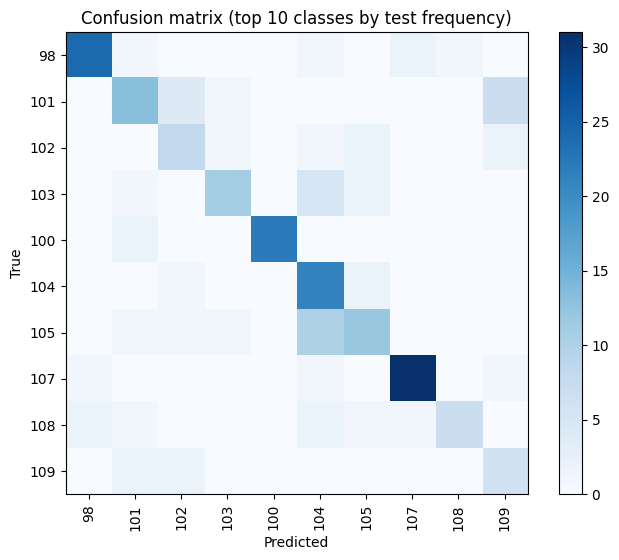


Classification report (top 10 classes):
              precision    recall  f1-score   support

          97       0.89      0.29      0.43        84
         100       0.62      0.15      0.25        84
         101       0.50      0.10      0.16        84
         102       0.79      0.13      0.22        84
          99       1.00      0.26      0.42        84
         103       0.51      0.25      0.34        84
         104       0.63      0.14      0.23        84
         106       0.91      0.37      0.53        84
         107       0.88      0.08      0.15        84
         108       0.38      0.07      0.12        84

   micro avg       0.71      0.18      0.29       840
   macro avg       0.71      0.18      0.28       840
weighted avg       0.71      0.18      0.28       840



In [13]:
# %%
# 10. Evaluation
pred_proba = model.predict(test_X)
pred = np.argmax(pred_proba, axis=1)
acc = accuracy_score(test_y, pred)
f1 = f1_score(test_y, pred, average='weighted')
print('Test accuracy:', acc)
print('Test weighted F1:', f1)

# Confusion matrix (may be large for 109 classes)
cm = confusion_matrix(test_y, pred)

# Plot a reduced confusion matrix for top-k most common classes in test set to make it interpretable
unique, counts = np.unique(test_y, return_counts=True)
topk_idx = np.argsort(counts)[-10:]
topk_classes = unique[topk_idx]
# Build reduced cm for these classes
mask = np.isin(test_y, topk_classes)
cm_small = confusion_matrix(test_y[mask], pred[mask], labels=topk_classes)
plt.figure(figsize=(8,6))
plt.imshow(cm_small, interpolation='nearest', cmap='Blues')
plt.title('Confusion matrix (top 10 classes by test frequency)')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(range(len(topk_classes)), topk_classes+1, rotation=90)
plt.yticks(range(len(topk_classes)), topk_classes+1)
plt.show()

print('\nClassification report (top 10 classes):')
print(classification_report(test_y[mask], pred[mask], labels=topk_classes, zero_division=0))


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Features shape: (9154, 64)


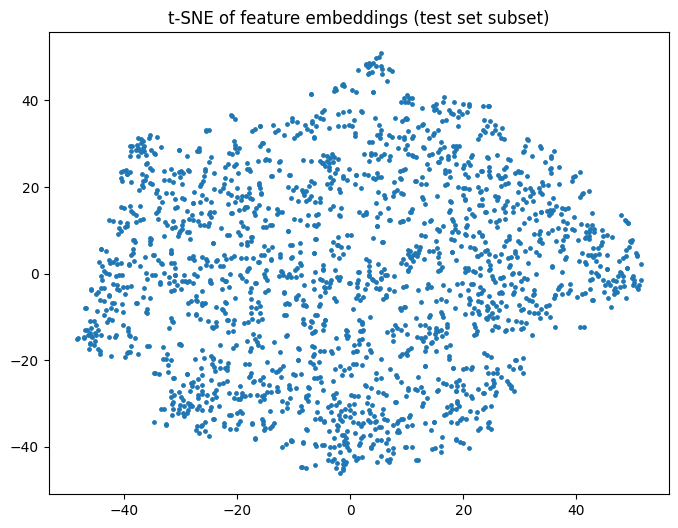

In [14]:


# %%
# 11. Feature embeddings + t-SNE (optional)
# Extract features from the penultimate layer (before softmax)
feature_extractor = models.Model(inputs=model.input, outputs=model.layers[-2].output)
features = feature_extractor.predict(test_X)
print('Features shape:', features.shape)

# Run t-SNE on subset if too large
subset = features
if subset.shape[0] > 2000:
    subset = subset[np.random.choice(subset.shape[0], 2000, replace=False)]

tsne = TSNE(n_components=2, random_state=42)
proj = tsne.fit_transform(subset)
plt.figure(figsize=(8,6))
plt.scatter(proj[:,0], proj[:,1], s=6)
plt.title('t-SNE of feature embeddings (test set subset)')
plt.show()


In [16]:


# %%
# 12. Save model and final notes
MODEL_SAVE = '/content/eeg_personid_model.h5'
model.save(MODEL_SAVE)
print('Saved model to', MODEL_SAVE)

# Final notes for the report (to copy into your performance report):
# - Dataset: EEG Motor Movement/Imagery (109 subjects) — windows of {WINDOW_SECONDS}s
# - Preprocessing: resampled to {SAMPLE_RATE} Hz, bandpass {FMIN}-{FMAX} Hz, mel-spectrogram (n_mels={N_MELS})
# - Model: Time-Frequency CNN (Conv2D blocks) + Temporal RNN (2x GRU) -> Softmax (109 classes)
# - Evaluation metrics produced: accuracy, weighted F1, confusion matrix (plotted for top classes), classification report
# - Optional visualizations included: example spectrograms, t-SNE of learned embeddings

# Tips:
# - This script uses a simple average across channels to produce a single-channel spectrogram per window.
#   Better results will come from using multi-channel inputs (e.g., treat channels as input channels),
#   or computing spatial filters (CSP) and using those features.
# - Training on the full dataset may require more time and GPU memory. If GPUs are limited, reduce MAX_WINDOWS_PER_FILE
#   or train on a subset of subjects for experimentation.
# - For cross-session evaluation, separate session files by their recording session (R01 vs R02) and ensure testing uses the other session.
# - Hyperparameters (window length, n_mels, model size) can be tuned for improved performance.


Saved model to /content/eeg_personid_model.h5
